# Final Project Training Data

**EEL 5840 Fundamentals of Machine Learning**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow as tf
from sklearn.metrics import accuracy_score
from skimage.transform import resize 
from PIL import Image

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
import itertools
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

In [3]:
def preprocess(data = None, labels = None):
    # Load the data from npy files (train data)
    X_train = np.load(data)
    if labels != None:
        y_train = np.load(labels)
    
    # Normalize the train data to [0,1]
    scaler = MinMaxScaler()
    X_train=scaler.fit_transform(X_train)
    
    # No. of samples
    N = X_train.shape[1]
    
    # Converting 1D array to Image of size 300x300
    X_t= np.empty((N,300,300))
    for j in range(N):
        X_t[j] = X_train[:,j].reshape((300,300))
        
    # Cubic Resampling to width x height of the specified no of dimensions
    w = 50
    h = 50
    X_train = np.empty((N,50,50))
    for j in range(N):
        X_train[j] = Image.fromarray(X_t[j]).resize(size=(h, w))
    
    if labels != None:
        return X_train, y_train
    else:
        return X_train


In [4]:
def data_prep(X_train, y_train):
    #Splitting the data into training and test set
    X_train, X_test, y_train, y_test = train_test_split( X_train, y_train, test_size=0.2, random_state=3)
    
    # reshape to be [samples][width][height][channels]
    X_train = X_train.reshape((X_train.shape[0], 50, 50, 1)).astype('float32')
    X_test = X_test.reshape(X_test.shape[0], 50, 50, 1).astype('float32')
    
    # one hot encode outputs
    y_train = to_categorical(y_train,num_classes=10)
    y_test = to_categorical(y_test,num_classes=10)
    
    #Performing data Augumentation on the image
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


    datagen.fit(X_train)
    
    return X_train, X_test, y_train, y_test, datagen

In [5]:
def CNN_Model(inp_shape):
    # create model
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = inp_shape))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))


    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    # Compile model
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    return model

In [6]:
#Plotting the confusion matrix of the test  result
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(20,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [7]:
def train(data_npy, labels_npy, no_of_epochs, batch_N, minimum_lr):
    
    X_train, y_train = preprocess(data_npy,labels_npy)
    X_train, X_test, y_train, y_test, datagen = data_prep(X_train, y_train)
    
    #Adaptively changing the learning rate
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',  patience=5, verbose=1, factor=0.2,  min_lr=minimum_lr)
    epochs = no_of_epochs
    batch_size = batch_N
    
    #Input_shape
    inp_shape = X_train[0,:].shape
    
    # build the model
    model = CNN_Model(inp_shape)
    # Fit the model
    history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_test,y_test),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])
    # Final evaluation of the model
    scores = model.evaluate(X_test, y_test, verbose=0)
    print(" Final Test Accuracy: %.2f%%" % (scores[1]*100))
    
    #Plotting the accuracy and loss curve6j
    f = plt.figure(figsize=(20,7))

    #Adding Subplot 1 (For Accuracy)
    f.add_subplot(121)

    plt.plot(history.epoch,history.history['accuracy'],label = "accuracy") # Accuracy curve for training set
    plt.plot(history.epoch,history.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

    plt.title("Accuracy Curve",fontsize=18)
    plt.xlabel("Epochs",fontsize=15)
    plt.ylabel("Accuracy",fontsize=15)
    plt.grid(alpha=0.3)
    plt.legend()

    #Adding Subplot 1 (For Loss)
    f.add_subplot(122)

    plt.plot(history.epoch,history.history['loss'],label="loss") # Loss curve for training set
    plt.plot(history.epoch,history.history['val_loss'],label="val_loss") # Loss curve for validation set

    plt.title("Loss Curve",fontsize=18)
    plt.xlabel("Epochs",fontsize=15)
    plt.ylabel("Loss",fontsize=15)
    plt.grid(alpha=0.3)
    plt.legend()

    plt.show()
    
    # Predict the values from the validation dataset
    Y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    y_test = np.argmax(y_test,axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(y_test, Y_pred_classes) 
    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes = range(10)) 
    
    model.save('final_model_with_norm.h5')

2022-04-20 19:31:48.663349: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:/opt/slurm/lib64:
2022-04-20 19:31:48.663391: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-20 19:31:48.663415: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c21b-s20.ufhpc): /proc/driver/nvidia/version does not exist
2022-04-20 19:31:48.663737: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/apps/tensorflow/2.7.0/lib/python3.9/

Epoch 1/100
84/84 - 116s - loss: 2.2764 - accuracy: 0.1339 - val_loss: 1.8288 - val_accuracy: 0.4122 - lr: 0.0010 - 116s/epoch - 1s/step
Epoch 2/100
84/84 - 115s - loss: 1.8920 - accuracy: 0.3283 - val_loss: 1.3440 - val_accuracy: 0.6109 - lr: 0.0010 - 115s/epoch - 1s/step
Epoch 3/100
84/84 - 114s - loss: 1.5316 - accuracy: 0.4844 - val_loss: 1.0286 - val_accuracy: 0.7083 - lr: 0.0010 - 114s/epoch - 1s/step
Epoch 4/100
84/84 - 114s - loss: 1.2577 - accuracy: 0.5904 - val_loss: 0.7971 - val_accuracy: 0.7545 - lr: 0.0010 - 114s/epoch - 1s/step
Epoch 5/100
84/84 - 114s - loss: 1.0996 - accuracy: 0.6417 - val_loss: 0.6999 - val_accuracy: 0.7783 - lr: 0.0010 - 114s/epoch - 1s/step
Epoch 6/100
84/84 - 114s - loss: 1.0048 - accuracy: 0.6741 - val_loss: 0.6503 - val_accuracy: 0.7894 - lr: 0.0010 - 114s/epoch - 1s/step
Epoch 7/100
84/84 - 115s - loss: 0.8911 - accuracy: 0.7113 - val_loss: 0.5592 - val_accuracy: 0.8170 - lr: 0.0010 - 115s/epoch - 1s/step
Epoch 8/100
84/84 - 113s - loss: 0.8419 -

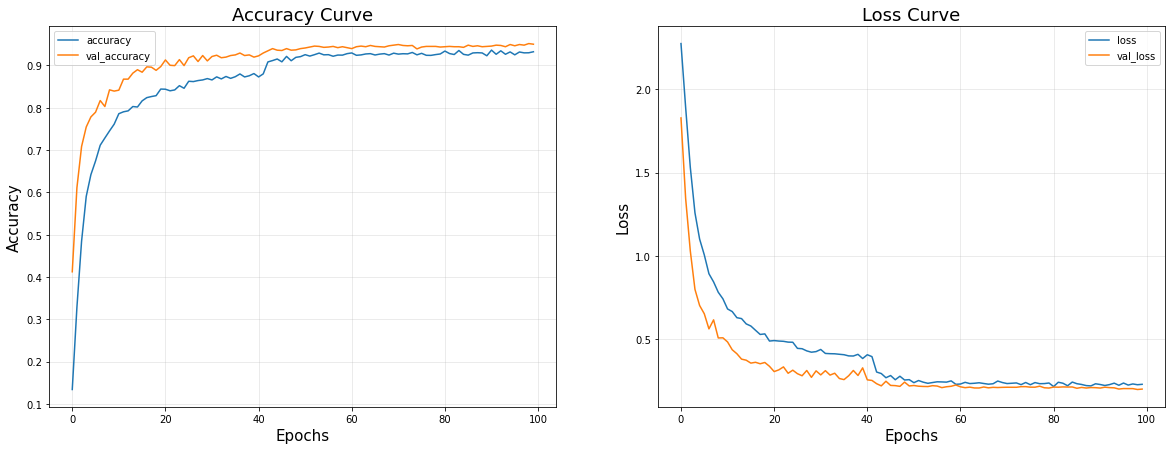

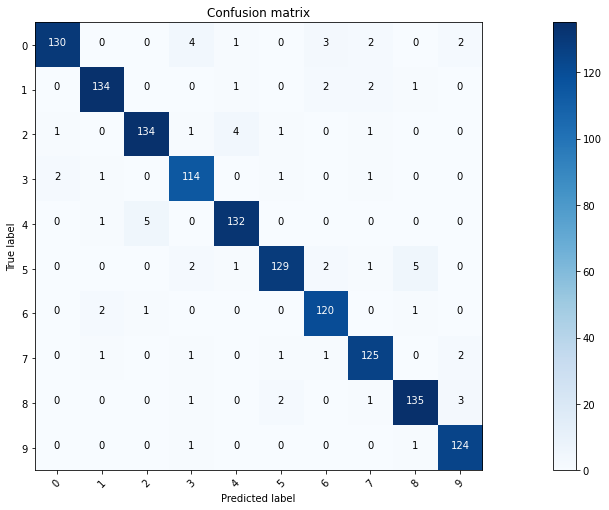

In [8]:
if __name__ == '__main__':
    # Training the model with 100 epochs, 64 batch size and minimum learning rate as 0.00005 with image samples to 50x50
    train("data_train.npy", "labels_train.npy", 100, 64, 0.00005)
    